In [23]:
#%% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import ast
from scipy.ndimage import gaussian_filter
import pickle
import scipy.stats
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [9]:
#%%
num_participants = 64
errors = np.zeros((num_participants, 768))
its = np.zeros((768))
mts = np.zeros((768))

In [10]:
#%%
def euclidean_dist(df):
    errors = list()
    for i in range(len(df)):
        errors.append(np.sqrt((df['target_x'][i] - df['transfer_mouse.x'][i][-1])**2 + (df['target_y'][i] - df['transfer_mouse.y'][i][-1])**2))        

    return errors       
def angular_dist(vec1, vec2, signed = False):
    
    uv1 = vec1/np.linalg.norm(vec1)
    uv2 = vec2/np.linalg.norm(vec2)
    dot_prod = np.dot(uv1, uv2)
    cross_prod = np.cross(uv1, uv2)
    if cross_prod < 0:
        sign = -1
    else:
        sign = 1
    if not signed:
        sign = 1
    return sign*np.arccos(dot_prod)

def rotate(x, y, angle):
    radians = (np.pi/180)*angle
    cos_val = np.cos(radians)
    sin_val = np.sin(radians)
    nx = x*cos_val + y*sin_val
    ny = y*cos_val - x*sin_val
    return [nx, ny];


# Preprocessing

## 0. Read Data

In [11]:
def data_read(participant):
    return pd.read_csv('data/'+str(participant)+'.csv')

## 1. Data Cleanup 

In [12]:
def data_cleanup(data):
    #Preliminary cleanup. Includes dropping NAs, separating in three sets and resetting indices to start from 0
    data_baseline = data.dropna(subset = ['baseline_mouse.x'], inplace = False)
    data_baseline.dropna('columns', inplace = True)
    data_baseline.reset_index(drop = True, inplace = True)
    
    data_rotated = data.dropna(subset = ['rotated_mouse.x'], inplace = False)
    data_rotated.dropna('columns', inplace = True)
    data_rotated.reset_index(drop = True, inplace = True)
    
    data_transfer = data.dropna(subset = ['transfer_mouse.x'], inplace = False)
    data_transfer.dropna('columns', inplace = True)
    data_transfer.reset_index(drop = True, inplace = True)
    
    #Convert string lists to regular lists
    for column in data_rotated.columns:
        try:
            data_rotated[column] = data_rotated[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_baseline.columns:
        try:
            data_baseline[column] = data_baseline[column].apply(ast.literal_eval)
        except:
            continue
            #print()
    for column in data_transfer.columns:
        try:
            data_transfer[column] = data_transfer[column].apply(ast.literal_eval)            
        except:
            continue
            #print()


    return data_baseline, data_rotated, data_transfer

## 2. Reading fixation positions

In [13]:
def get_fix_positions(cleaned_data, participant):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            baseline_fix_pos[trial][:] = np.array(rotate(data_baseline['baseline_mouse.x'][trial][-1], data_baseline['baseline_mouse.y'][trial][-1], 0))        
        except:
            continue
    rotated_fix_pos = np.zeros((640, 2))
    if participant%2 == 0:
        for trial in range(640):
            try:
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], 90))        
            except:
                continue
    else:
        for trial in range(640):
            try:
                rotation = int(trial/64 + 1) * 10
                if rotation > 90:
                    rotation = 90
                #rotation = 0
                #print(rotation)
                rotated_fix_pos[trial][:] = np.array(rotate(data_rotated['rotated_mouse.x'][trial][-1], data_rotated['rotated_mouse.y'][trial][-1], rotation))
            except:
                #print (participant, trial)
                continue
                #print()
    transfer_fix_pos = np.zeros((64, 2))
    for trial in range(64):
        try:
            transfer_fix_pos[trial][:] = np.array(rotate(data_transfer['transfer_mouse.x'][trial][-1], data_transfer['transfer_mouse.y'][trial][-1], 0))        
        except:
            print(participant, trial)
            continue
            #print()
    return baseline_fix_pos, rotated_fix_pos, transfer_fix_pos

## 3. Calculating euclidean and angular errors

In [14]:
def calc_error(cleaned_data, fix_position, signed):
    data_baseline, data_rotated, data_transfer = cleaned_data
    baseline_fix_pos, rotated_fix_pos, transfer_fix_pos = fix_position
    errors = np.zeros(768)
    ang_errors = np.zeros(768)
    for trial in range(64):
        errors[trial] = np.sqrt((baseline_fix_pos[trial][0] - data_baseline['target_x'][trial])**2 + (baseline_fix_pos[trial][1] - data_baseline['target_y'][trial])**2)
        ang_errors[trial] = angular_dist(baseline_fix_pos[trial], [data_baseline['target_x'][trial], data_baseline['target_y'][trial]], signed)
    for trial in range(640):
        errors[trial+64] = np.sqrt((rotated_fix_pos[trial][0] - data_rotated['target_x'][trial])**2 + (rotated_fix_pos[trial][1] - data_rotated['target_y'][trial])**2)
        ang_errors[trial+64] = angular_dist(rotated_fix_pos[trial], [data_rotated['target_x'][trial], data_rotated['target_y'][trial]], signed)
    for trial in range(64):
        errors[trial+704] = np.sqrt((transfer_fix_pos[trial][0] - data_transfer['target_x'][trial])**2 + (transfer_fix_pos[trial][1] - data_transfer['target_y'][trial])**2)
        ang_errors[trial+704] = angular_dist(transfer_fix_pos[trial], [data_transfer['target_x'][trial], data_transfer['target_y'][trial]], signed)
    return errors, ang_errors

## 4. Pipeline to calculate errors for each participant

In [15]:
def get_errors(participant, signed = False):
    data = data_read(participant)
    cleaned_data = data_cleanup(data)
    fix_position = get_fix_positions(cleaned_data, participant)
    errors, ang_errors = calc_error(cleaned_data, fix_position, signed)
    #ang_errors = np.nan_to_num(ang_errors, nan = np.nanmean(ang_errors))
    d = {'trial': range(768),
        'errors_temp': errors,
        'ang_errors_temp': ang_errors}
    df = pd.DataFrame(d)
    df['errors'] = df['errors_temp'].interpolate()
    df['ang_errors'] = df['ang_errors_temp'].interpolate()
    return df

In [33]:
a, b, c = data_cleanup(data_read(2024))

Text(0.5, 1.0, 'Rotation Phase')

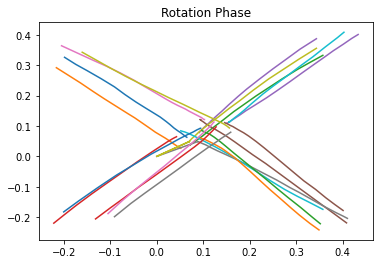

In [35]:
for i in range(520, 540):
    plt.plot(b['rotated_mouse.x'][i], b['rotated_mouse.y'][i])
plt.title('Rotation Phase')

In [72]:
num_participants = 64
unsigned_ang_errors = np.zeros((num_participants, 768))
ang_errors = np.zeros((num_participants, 768))

errors = np.zeros((num_participants, 768))
participant_ang_errors = np.zeros(num_participants, dtype = object)
for i, participant in enumerate(np.concatenate((range(32), range(60-6, 92-6)))):
    errors_df = get_errors(participant+2006)
    unsigned_ang_errors[i] = errors_df['ang_errors']
    errors_df = get_errors(participant+2006, signed=True)
    ang_errors[i] = errors_df['ang_errors']
    

    # errors[participant] = gaussian_filter(errors_df['errors'], sigma = 2)
    # participant_ang_errors[participant] = gaussian_filter(errors_df['ang_errors'], sigma = 2)

2020 0
2020 0
2029 0
2029 0
2071 0
2071 1
2071 3
2071 4
2071 5
2071 6
2071 7
2071 8
2071 9
2071 10
2071 11
2071 12
2071 13
2071 14
2071 15
2071 16
2071 17
2071 19
2071 21
2071 22
2071 23
2071 24
2071 25
2071 26
2071 27
2071 28
2071 29
2071 30
2071 31
2071 32
2071 33
2071 34
2071 35
2071 36
2071 37
2071 38
2071 39
2071 40
2071 41
2071 42
2071 43
2071 44
2071 45
2071 46
2071 48
2071 49
2071 50
2071 51
2071 52
2071 53
2071 54
2071 55
2071 56
2071 57
2071 58
2071 61
2071 62
2071 63
2071 0
2071 1
2071 3
2071 4
2071 5
2071 6
2071 7
2071 8
2071 9
2071 10
2071 11
2071 12
2071 13
2071 14
2071 15
2071 16
2071 17
2071 19
2071 21
2071 22
2071 23
2071 24
2071 25
2071 26
2071 27
2071 28
2071 29
2071 30
2071 31
2071 32
2071 33
2071 34
2071 35
2071 36
2071 37
2071 38
2071 39
2071 40
2071 41
2071 42
2071 43
2071 44
2071 45
2071 46
2071 48
2071 49
2071 50
2071 51
2071 52
2071 53
2071 54
2071 55
2071 56
2071 57
2071 58
2071 61
2071 62
2071 63
2074 6
2074 7
2074 25
2074 26
2074 27
2074 28
2074 6
2074 7
20

In [73]:
errors = pd.DataFrame({'participant': np.repeat(np.arange(64), 768), 
                   'trial': np.tile(np.arange(768), 64),
                   'block': np.tile(np.repeat(np.arange(12), 64), 64),
                   'errors': np.ravel(ang_errors)*180/np.pi,
                   'Rotation': np.tile(np.repeat(['Sudden', 'Gradual'], 768), 32),
                   'Emphasis': np.repeat(['Accuracy', 'Speed'], 768*32),  
                   'unsigned errors': np.ravel(unsigned_ang_errors)*180/np.pi
                                    
                   }
                   )

In [74]:
smoothed_errors = []
unsigned_smoothed_errors = []

for participant in range(64):
    for block in range(12):
        smoothed_errors.append(gaussian_filter(errors.loc[((errors['participant'] == participant) & (errors['block'] == block)), 'errors'], sigma=2))
        unsigned_smoothed_errors.append(gaussian_filter(errors.loc[((errors['participant'] == participant) & (errors['block'] == block)), 'unsigned errors'], sigma=2))
        

In [75]:
errors['avg smooth errors degrees'] = np.ravel(smoothed_errors)
errors['avg smooth unsigned errors degrees'] = np.ravel(unsigned_smoothed_errors)


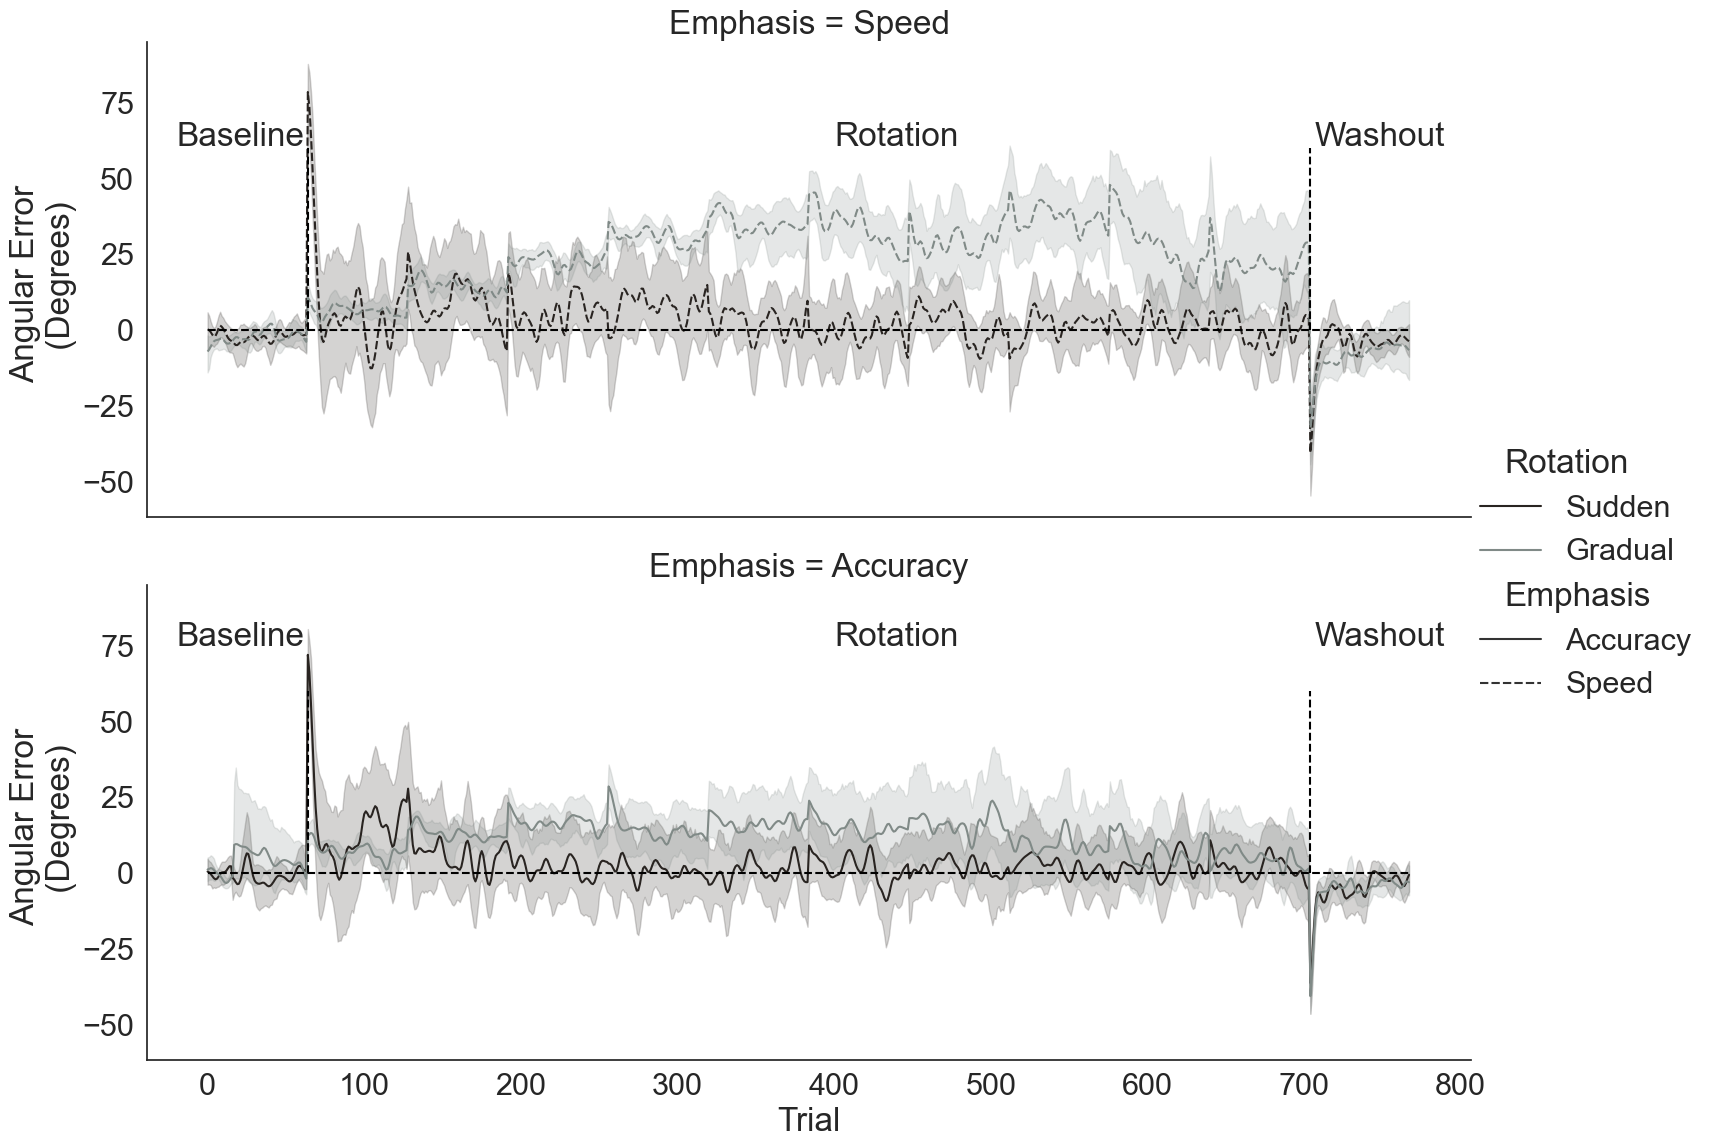

In [122]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial', y = 'avg smooth errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = errors, height = 6, aspect = 2.5, kind = 'line', linewidth = 1.5)
g.set_axis_labels('Trial', 'Angular Error \n (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=60, ymin = 0, color = 'black', linestyles = '--')
    ax.vlines(x = 704, ymax=60, ymin = 0, color = 'black', linestyles = '--')
    # ax.vlines(x = 576, ymax=60, ymin = 0, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 768, color = 'black', linestyles = '--')


plt.text(x = -20, y = 75, s = 'Baseline')
plt.text(x = 400, y = 75, s = 'Rotation')
# plt.text(x = 512, y = 75, s = 'Unlearn')
plt.text(x = 707, y = 75, s = 'Washout')


plt.text(x = -20, y = 240, s = 'Baseline')
plt.text(x = 400, y = 240, s = 'Rotation')
# plt.text(x = 512, y = 75, s = 'Unlearn')
plt.text(x = 707, y = 240, s = 'Washout')

sns.despine(bottom=False, left=False)


In [106]:
blockwise_errors = errors.groupby(['participant', 'Rotation', 'Emphasis', 'block']).mean().reset_index()

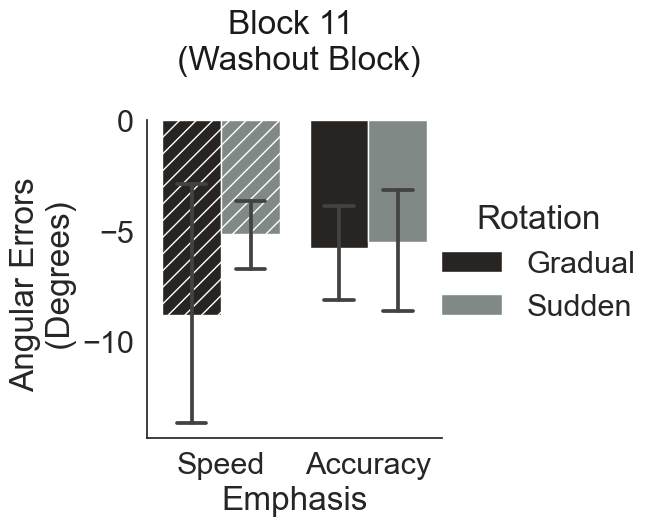

In [121]:
g = sns.catplot(x = 'Emphasis', hue = 'Rotation', y = 'avg smooth errors degrees', col = 'block',
            data = blockwise_errors.loc[((blockwise_errors['block']==11))],
            kind = 'bar', capsize = 0.2, hue_order=['Gradual', 'Sudden'], order = ['Speed', 'Accuracy']
            )
x1, x2 = 0, 1
y, h, col = blockwise_errors.loc[(blockwise_errors['block'] == 11)]['avg smooth unsigned errors degrees'].max(), 0.02, 'k'
plt.text(0.5, 2, "Block 11 \n (Washout Block)", ha='center', va='bottom', color=col)
# plt.text(0.5, y+h-27, "*", ha='center', va='bottom', color=col)
# plt.axhline(xmin=0.25, xmax=0.75, y = y+h-23)

# plt.text(0, y+h-42, "*", ha='center', va='bottom', color=col)
# plt.axhline(xmin=0.125, xmax=0.375, y = y+h-39)

# plt.text(1, y+h-42, "*", ha='center', va='bottom', color=col)
# plt.axhline(xmin=0.625, xmax=0.875, y = y+h-39)

# g.set(ylim=((0, 70)))
g.set(ylabel='Angular Errors \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [115]:

blockwise_errors['avg_signed_errors_degrees'] = blockwise_errors['avg smooth errors degrees']
model = ols(
    'avg_signed_errors_degrees ~ C(Rotation) * C(Emphasis)', data=blockwise_errors.loc[((blockwise_errors['block']==11))]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),61.716322,1.0,1.203660,0.276975
C(Emphasis),29.093583,1.0,0.567415,0.454234
C(Rotation):C(Emphasis),45.383672,1.0,0.885123,0.350575
Residual,3076.432587,60.0,NaN,NaN


In [29]:
curvatures_smooth = ang_errors.reshape((num_participants, 12, 64))

In [60]:
curvatures_smooth_accuracy = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth_speed = pickle.load(open('curvatures_smooth_speed.pickle', 'rb'))

In [61]:
curvatures_smooth = np.concatenate((curvatures_smooth_accuracy, curvatures_smooth_speed))

In [63]:
#First 32 are accuracy, last 32 are speed emphasis
pickle.dump(curvatures_smooth, open('curvatures_smooth_all.pickle', 'wb'))

In [65]:
curvatures_smooth = curvatures_smooth.reshape(64, 768)

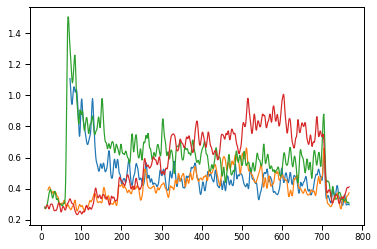

In [68]:
plt.plot(np.mean(curvatures_smooth[0:32:2], axis = 0))
plt.plot(np.mean(curvatures_smooth[1:32:2], axis = 0))
plt.plot(np.mean(curvatures_smooth[32::2], axis = 0))
plt.plot(np.mean(curvatures_smooth[33::2], axis = 0))


In [73]:
curvature_errors_df.to_csv('curvature_errors_all.csv')

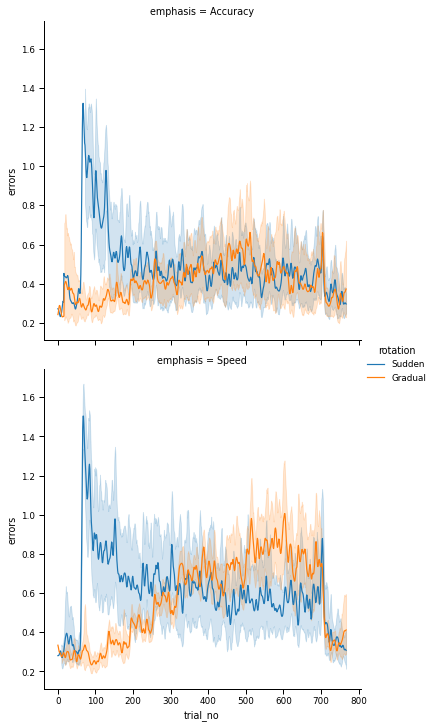

In [72]:
sns.relplot(x = 'trial_no', y = 'errors', hue = 'rotation', row = 'emphasis', 
            data = curvature_errors_df, kind='line')

# RTs

In [213]:
a.columns

Index(['target_x', 'target_y', 'rotation', 'baseline_trials.thisRepN',
       'baseline_trials.thisTrialN', 'baseline_trials.thisN',
       'baseline_trials.thisIndex', 'baseline_enclosing_1.started',
       'baseline_enclosing_1.stopped', 'baseline_enclosing.started',
       'baseline_enclosing.stopped', 'baseline_target.started',
       'baseline_target.stopped', 'baseline_fixation.started',
       'baseline_fixation.stopped', 'baseline_mouse.x', 'baseline_mouse.y',
       'baseline_mouse.leftButton', 'baseline_mouse.midButton',
       'baseline_mouse.rightButton', 'baseline_mouse.time',
       'baseline_mouse.started', 'baseline_mouse.stopped',
       'baseline_enclosing_feedback_1.started',
       'baseline_enclosing_feedback_1.stopped',
       'baseline_enclosing_feedback.started',
       'baseline_enclosing_feedback.stopped',
       'baseline_target_feedback.started', 'baseline_target_feedback.stopped',
       'baseline_fixation_feedback.started',
       'baseline_fixation_feedba

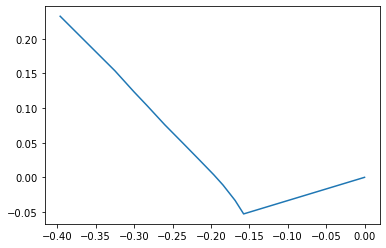

In [223]:
plt.plot(np.array(a['baseline_mouse.x'][trial]), np.array(a['baseline_mouse.y'][trial]))

In [ ]:
its = np.zeros((num_participants, 768))
mts = np.zeros((num_participants, 768))

for i, participant in enumerate(np.concatenate((range(32), range(60-6, 92-6)))):
    a, b, c = data_cleanup(data_read(participant+2006))
    for trial in range(64):
        if len(np.array(a['baseline_mouse.time'][trial])[np.array(a['baseline_mouse.leftButton'][trial]) == 1]) > 0:
            its[i, trial] = np.array(a['baseline_mouse.time'][trial])[np.array(a['baseline_mouse.leftButton'][trial]) == 1][0]
            mts[i, trial] = np.array(a['baseline_mouse.time'][trial])[np.array(a['baseline_mouse.leftButton'][trial]) == 1][-1]
        # except:
        #     print(participant, trial)        
    for trial in range(640):
        if len(np.array(b['rotated_mouse.time'][trial])[np.array(b['rotated_mouse.leftButton'][trial]) == 1]) > 0:
            its[i, trial+64] = np.array(b['rotated_mouse.time'][trial])[np.array(b['rotated_mouse.leftButton'][trial]) == 1][0]
            mts[i, trial+64] = np.array(b['rotated_mouse.time'][trial])[np.array(b['rotated_mouse.leftButton'][trial]) == 1][-1]
        # except:
        #     print(participant, trial+64)
    for trial in range(64):
        if len(np.array(c['transfer_mouse.time'][trial])[np.array(c['transfer_mouse.leftButton'][trial]) == 1]) > 0:
            its[i, trial+704] = np.array(c['transfer_mouse.time'][trial])[np.array(c['transfer_mouse.leftButton'][trial]) == 1][0]
            mts[i, trial+704] = np.array(c['transfer_mouse.time'][trial])[np.array(c['transfer_mouse.leftButton'][trial]) == 1][-1]
        # except:
        #     print(participant,trial+704)        
    print(its.shape)


(array([0.58600262, 0.78133683, 1.17200524, 1.95334207, 0.78133683,
        0.39066841, 1.36733945, 0.78133683, 0.97667104, 0.58600262,
        0.39066841, 0.19533421, 0.19533421, 0.39066841, 0.19533421,
        0.19533421, 0.19533421, 0.        , 0.39066841, 0.19533421,
        0.        , 0.39066841, 0.        , 0.        , 0.        ,
        0.19533421, 0.        , 0.        , 0.        , 0.19533421]),
 array([0.45024025, 0.53023136, 0.61022247, 0.69021358, 0.77020469,
        0.8501958 , 0.93018691, 1.01017802, 1.09016913, 1.17016024,
        1.25015135, 1.33014246, 1.41013357, 1.49012468, 1.57011579,
        1.6501069 , 1.73009801, 1.81008912, 1.89008023, 1.97007134,
        2.05006245, 2.13005356, 2.21004467, 2.29003578, 2.37002689,
        2.450018  , 2.5300091 , 2.61000021, 2.68999132, 2.76998243,
        2.84997354]),
 <BarContainer object of 30 artists>)

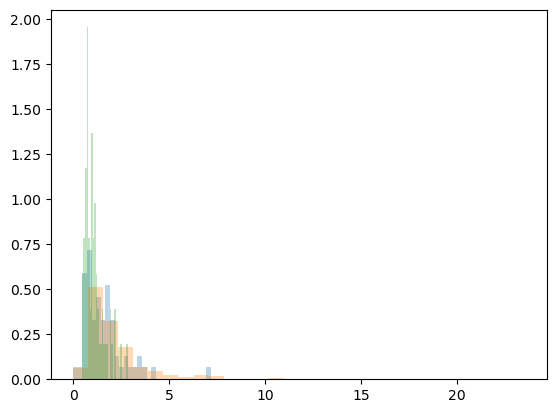

In [9]:
plt.hist(its[13][:64], bins = 30, alpha = 0.3, density=True)
plt.hist(its[13][64:704], bins = 30, alpha = 0.3, density=True)
plt.hist(its[13][704:], bins = 30, alpha = 0.3, density=True)

In [85]:
total_time = gaussian_filter(c['transfer_fixation_feedback.started'] - c['transfer_fixation.started'], sigma = 2)

In [18]:
rts = pd.DataFrame({'participant': np.repeat(np.arange(64), 768), 
                   'trial': np.tile(np.arange(768), 64),
                   'block': np.tile(np.repeat(np.arange(12), 64), 64),
                   'ITs': np.ravel(its),
                   'MTs': np.ravel(mts),
                   'TT': np.ravel(its) + np.ravel(mts),
                   'Rotation': np.tile(np.repeat(['Sudden', 'Gradual'], 768), 32),
                   'Emphasis': np.repeat(['Accuracy', 'Speed'], 768*32)
                   }
                   )

In [26]:
its

array([[7.36506190e-05, 0.00000000e+00, 0.00000000e+00, ...,
        6.60871510e-01, 4.50286890e-01, 5.50614424e-01],
       [7.54611101e-05, 0.00000000e+00, 0.00000000e+00, ...,
        1.33341443e+00, 9.66668156e-01, 1.35027368e+00],
       [1.34019181e-04, 0.00000000e+00, 0.00000000e+00, ...,
        5.66869848e-01, 7.00231938e-01, 1.06669085e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 7.16926650e-01, ...,
        5.00467122e-01, 3.83786001e-01, 1.48372983e+00],
       [4.66908687e-01, 1.68372433e+00, 2.60025524e+00, ...,
        2.08364929e+00, 1.20042717e+00, 5.67178267e-01],
       [9.10904251e-01, 7.60797351e-01, 9.00660716e-01, ...,
        5.71673198e-01, 4.30894326e-01, 4.91920871e-01]])

In [19]:
blockwise = rts.groupby(['participant', 'block', 'Rotation', 'Emphasis']).median().reset_index()

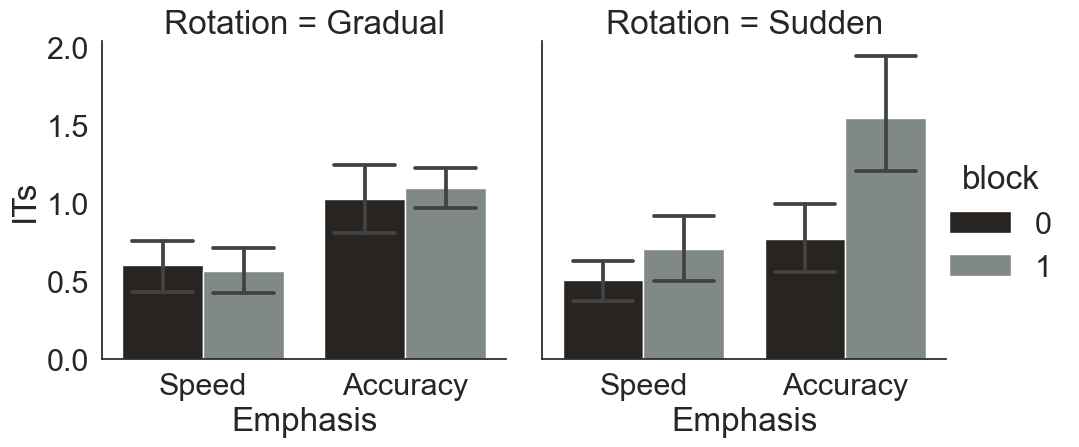

In [44]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

sns.catplot(x = 'Emphasis', y = 'ITs', hue = 'block', col = 'Rotation', 
            data = blockwise.loc[blockwise['block'] <= 1], 
            kind = 'bar', capsize = .3, order = ['Speed', 'Accuracy'], col_order = ['Gradual', 'Sudden'])

In [48]:
model = ols(
    'TT ~ C(Rotation) * C(Emphasis) * C(block)', data=blockwise.loc[((blockwise['block']<=1))]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),0.634819,1.0,0.739414,3.915633e-01
C(Emphasis),26.331884,1.0,30.670429,1.833669e-07
C(block),14.152046,1.0,16.483792,8.781333e-05
C(Rotation):C(Emphasis),0.024041,1.0,0.028002,8.673849e-01
C(Rotation):C(block),11.537785,1.0,13.438796,3.684734e-04
C(Emphasis):C(block),2.061561,1.0,2.401231,1.238731e-01
C(Rotation):C(Emphasis):C(block),1.474124,1.0,1.717007,1.925813e-01
Residual,103.025168,120.0,NaN,NaN


In [34]:
participantwise = blockwise.groupby(['participant', 'Rotation', 'Emphasis']).median().reset_index()

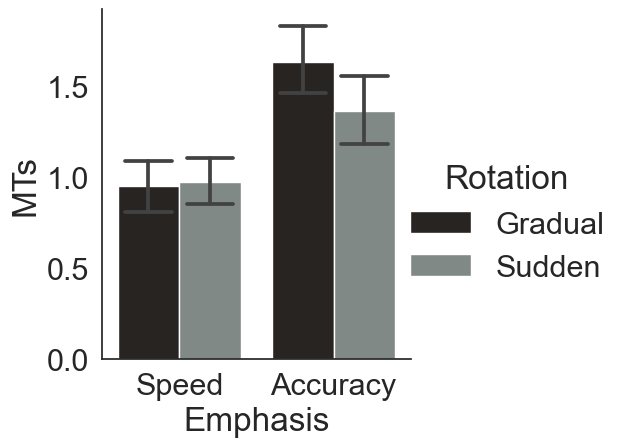

In [40]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

sns.catplot(x = 'Emphasis', y = 'MTs',  hue = 'Rotation', 
            data = participantwise, 
            kind = 'bar', capsize = .3, order = ['Speed', 'Accuracy'], hue_order = ['Gradual', 'Sudden'])

In [43]:
model = ols(
    'MTs ~ C(Rotation) * C(Emphasis)', data=participantwise).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),0.244907,1.0,2.094993,1.529874e-01
C(Emphasis),4.642424,1.0,39.712476,3.828210e-08
C(Rotation):C(Emphasis),0.341879,1.0,2.924519,9.241021e-02
Residual,7.014054,60.0,NaN,NaN


In [45]:
df_rt = pd.read_csv('RTs.csv')
df_rt

,Unnamed: 0,participant_id,condition,Trial,ITs,block,MTs
0,0,0,Sudden,0,0.000074,0,0.180820
1,1,1,Gradual,0,0.000075,0,0.274499
2,2,2,Sudden,0,0.000134,0,0.124207
3,3,3,Gradual,0,0.883418,0,0.133209
4,4,4,Sudden,0,0.920651,0,1.510810
...,...,...,...,...,...,...,...
10747,10747,9,Gradual,767,0.780795,11,0.190099
10748,10748,10,Sudden,767,0.733294,11,0.150234
10749,10749,11,Gradual,767,1.200126,11,0.216987
10750,10750,12,Sudden,767,0.560747,11,0.350405


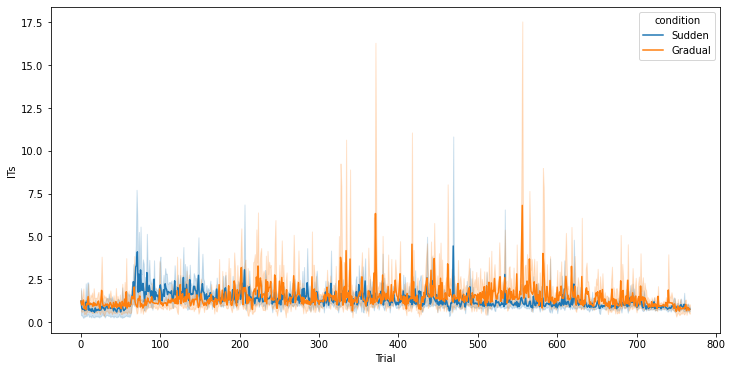

In [47]:
plt.figure(figsize=(12, 6))
lp = sns.lineplot(x = 'Trial', y = 'ITs', hue = 'condition', data = df_rt)


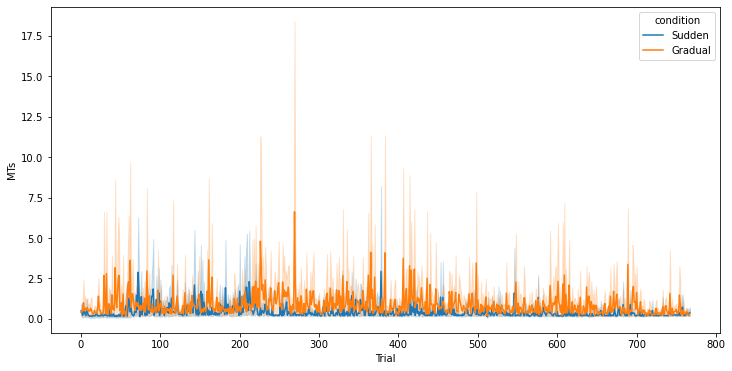

In [48]:
plt.figure(figsize=(12, 6))
lp = sns.lineplot(x = 'Trial', y = 'MTs', hue = 'condition', data = df_rt)
